# Diagnosis : repartition + pdfs on acc and distance to the matching point

In [9]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.sat as sat
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag

In [10]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49834/status,
Dashboard: http://127.0.0.1:49834/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52414,Workers: 8
Dashboard: http://127.0.0.1:49834/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:45279,Total threads: 7
Dashboard: http://127.0.0.1:47932/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:42735,


_______
## Load data

In [11]:
labels=cstes.labels

acc_bins=np.arange(-1e-4,1e-4,2e-6)
dist_bins=np.arange(0,1e5,2e3)
diag_list = [diag.diag_ind_pdfs, diag.diag_combined_pdfs]
bins_list = [ {"acc": acc_bins, "alti___distance" : dist_bins} ]*2

DS= {l: xr.open_zarr(cstes.zarr_dir+'/'+l+'.zarr').persist() for l in labels}
ds_acc_dist_pdfs = xr.concat([diag.diags(DS[key].isel( site_obs = DS[key].__site_matchup_indice.compute() )
                                .isel(alti_time=10)
                                .isel(alti_time_mid=10),
                                diag_list, bins_list) for key in DS],
                         dim=pd.Index(DS.keys(),name='drifter_sat_year'))

In [12]:
ds_acc_dist_pdfs = xr.open_zarr(cstes.zarr_dir+'/'+'acc_dist_pdfs.zarr').persist()

In [16]:
ds_acc_dist_pdfs


<xarray.Dataset>
Dimensions:                  (acc_bin: 100, alti___distance_bin: 49,
                              drifter_sat_year: 6)
Coordinates:
  * acc_bin                  (acc_bin) float64 -9.9e-05 -9.7e-05 ... 9.9e-05
  * alti___distance_bin      (alti___distance_bin) float64 1e+03 ... 9.7e+04
  * drifter_sat_year         (drifter_sat_year) object 'gps_SASSA_SARAL_2018'...
Data variables:
    nb_coloc                 (drifter_sat_year) int64 dask.array<chunksize=(6,), meta=np.ndarray>
    pdf_acc_x                (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>
    pdf_acc_y                (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>
    pdf_comb_x               (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>
    pdf_cor_grad_x           (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>
    pdf_coriolis_x           (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>
    pdf_coriolis_y           (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>
    pdf_g_grad_sla           (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>
    pdf_g_grad_sla_denoised  (drifter_sat_year, acc_bin, alti___distance_bin) float64 dask.array<chunksize=(6, 100, 49), meta=np.ndarray>

In [17]:
ds = diag.DS_mean_std_quartile(ds_acc_dist_pdfs, 'acc_bin')

In [18]:
ds

<xarray.Dataset>
Dimensions:                   (alti___distance_bin: 49, drifter_sat_year: 6)
Coordinates:
  * alti___distance_bin       (alti___distance_bin) float64 1e+03 ... 9.7e+04
  * drifter_sat_year          (drifter_sat_year) object 'gps_SASSA_SARAL_2018...
Data variables: (12/24)
    mean_acc_x                (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    var_acc_x                 (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    std_acc_x                 (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    mean_acc_y                (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    var_acc_y                 (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    std_acc_y                 (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    ...                        ...
    mean_g_grad_sla           (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    var_g_grad_sla            (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    std_g_grad_sla            (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    mean_g_grad_sla_denoised  (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    var_g_grad_sla_denoised   (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>
    std_g_grad_sla_denoised   (drifter_sat_year, alti___distance_bin) float64 dask.array<chunksize=(6, 49), meta=np.ndarray>

In [19]:
def ds_corr(ds_mean_var_std):
    """ Return dataset containing mean, variance, std for all pdfs in the given dataset
    
    Parameters
    ----------
    ds_mean_var_std : xarray Dataset
        dataset containing pdfs built by diags
    bin_dim : str
        bin dimension name
    """
#    list_pdf_name = [l.replace('pdf','') for l in list(ds_pdf.keys()) if 'pdf' in l]
    _ds=xr.Dataset()
    
    _ds['correlation_cor_grad_x']= (ds_mean_var_std.var_cor_grad_x
                                    -ds_mean_var_std.var_g_grad_sla_denoised
                                    -ds_mean_var_std.var_coriolis_x)/(2*ds_mean_var_std.std_g_grad_sla_denoised*ds_mean_var_std.std_coriolis_x)
    _ds['correlation_ag_acc_x']= (ds_mean_var_std.var_comb_x
                                    -ds_mean_var_std.var_acc_x
                                    -ds_mean_var_std.var_cor_grad_x)/(2*ds_mean_var_std.std_acc_x*ds_mean_var_std.std_cor_grad_x)
        
    return _ds

In [20]:
ds_corr=ds_corr(ds)

## Plots

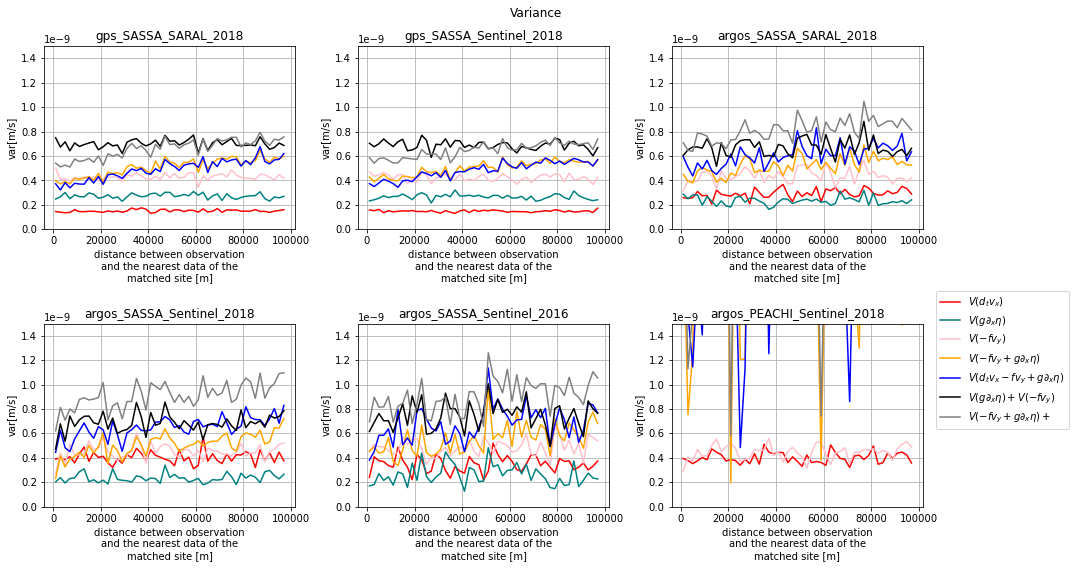

In [24]:
fig = plt.figure(figsize=(15,8))
j=0
n=len(ds['drifter_sat_year'])
for i in range (n):
    __ds=ds.isel(drifter_sat_year = i)
    ax = fig.add_subplot(2,int(np.ceil(n/2)),j+1)
    __ds.var_acc_x.plot( color='red', label=r"$V(d_tv_x)$", ax=ax)
    __ds.var_g_grad_sla_denoised.plot( color='teal', label=r"$V(g\partial_x\eta)$", ax=ax)
    __ds.var_coriolis_x.plot( color='pink', label=r"$V(-fv_y)$", ax=ax)
    __ds.var_cor_grad_x.plot( color='orange', label=r"$V(-fv_y+g\partial_x\eta)$", ax=ax)
    __ds.var_comb_x.plot( color='b', label=r"$V(d_tv_x-fv_y+g\partial_x\eta)$", ax=ax)
    (__ds.var_coriolis_x+__ds.var_g_grad_sla_denoised).plot( color='k', label=r"$V(g\partial_x\eta)+V(-fv_y)$", ax=ax)
    (__ds.var_cor_grad_x+__ds.var_acc_x).plot( color='grey', label=r"$V(-fv_y+g\partial_x\eta)+$", ax=ax)
    ax.set_title(ds.drifter_sat_year.values[i])
    j+=1
    ax.grid()
    ax.set_ylabel('var[m/s]')
    ax.set_ylim(0,15e-10)
ax.legend(loc='center right',bbox_to_anchor=(1.6, 0.8))

fig.suptitle(r"Variance")
fig.tight_layout()

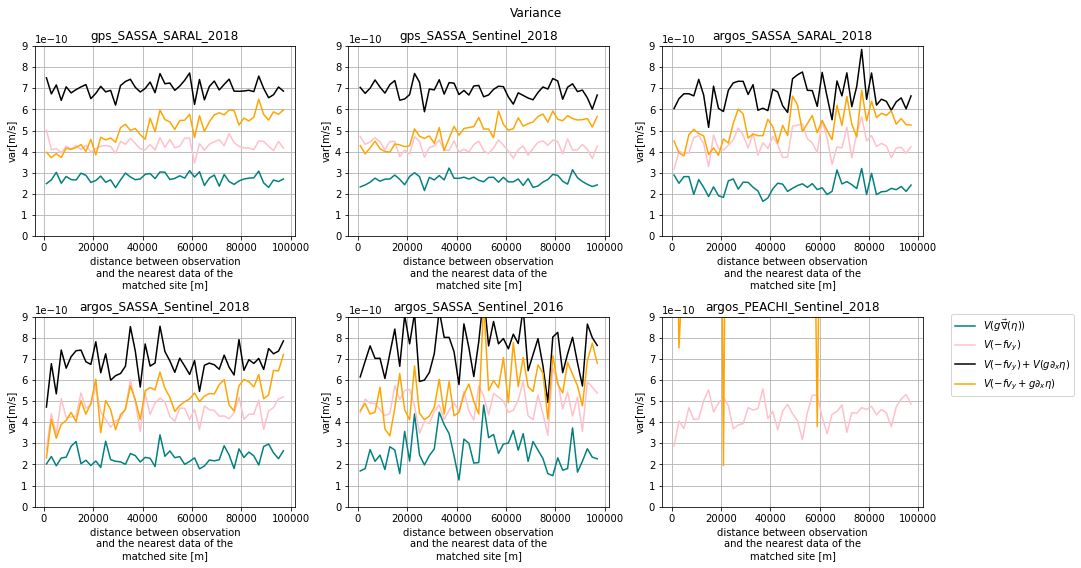

In [25]:
fig = plt.figure(figsize=(15,8))
j=0
n=len(ds['drifter_sat_year'])
for i in range (n):
    __ds=ds.isel(drifter_sat_year = i)
    ax = fig.add_subplot(2,int(np.ceil(n/2)),j+1)
    __ds.var_g_grad_sla_denoised.plot( color='teal', label=r"$V(g\vec{\nabla}(\eta))$", ax=ax)
    __ds.var_coriolis_x.plot( color='pink', label=r"$V(-fv_y)$", ax=ax)
    (__ds.var_coriolis_x+__ds.var_g_grad_sla_denoised).plot( color='k', label=r"$V(-fv_y)+V(g\partial_x\eta)$", ax=ax)
    __ds.var_cor_grad_x.plot( color='orange', label=r"$V(-fv_y+g\partial_x\eta)$", ax=ax)

    ax.set_title(ds.drifter_sat_year.values[i])
    j+=1
    ax.grid()
    ax.set_ylabel('var[m/s]')
    ax.set_ylim(0,9e-10)
ax.legend(loc='center right',bbox_to_anchor=(1.6, 0.8))

fig.suptitle(r"Variance")
fig.tight_layout()

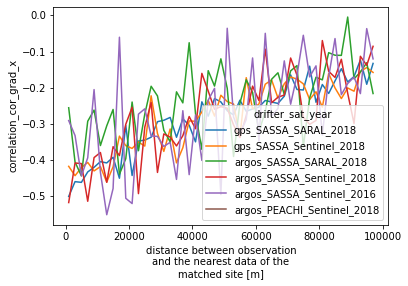

In [26]:
ds_corr.correlation_cor_grad_x.plot(hue='drifter_sat_year')

In [ ]:
fig = plt.figure(figsize=(15,8))
j=0
n=len(ds['drifter_sat_year'])
for i in range (n):
    __ds=ds.isel(drifter_sat_year = i)
    ax = fig.add_subplot(2,int(np.ceil(n/2)),j+1)
    __ds.var_acc_x.plot( color='red', label=r"$V(d_tv_x)$", ax=ax)
    __ds.var_cor_grad_x.plot( color='orange', label=r"$V(-fv_y+g\partial_x\eta)$", ax=ax)
    (__ds.var_cor_grad_x+__ds.var_acc_x).plot( color='grey', label=r"$V(d_tv_x)+V(-fv_y+g\partial_x\eta)$", ax=ax)
    __ds.var_comb_x.plot( color='b', label=r"$V(d_tv_x-fv_y+g\partial_x\eta)$", ax=ax)
    ax.set_title(ds.drifter_sat_year.values[i])
    j+=1
    ax.grid()
    ax.set_ylabel('var[m/s]')
    ax.set_ylim(0,9e-10)
ax.legend(loc='center right',bbox_to_anchor=(1.6, 0.8))

fig.suptitle(r"Variance")
fig.tight_layout()

In [ ]:
ds_corr.correlation_ag_acc_x.plot(hue='drifter_sat_year')